# **California Housing Price Prediction with Neural Networks**

In this notebook, we aim to build and evaluate a neural network model for predicting housing prices in California based on various features such as median income, average number of rooms, and house age. The goal is to establish a baseline deep learning model and explore ways to improve its performance.

## **Dataset Overview**
We use the **California Housing dataset**, which contains information on **housing prices** in different districts of California. The dataset includes **eight numerical features**, such as:

- `MedInc`: Median income of the district  
- `HouseAge`: Average age of houses  
- `AveRooms`: Average number of rooms per household  
- `AveBedrms`: Average number of bedrooms per household
- `Population`: Total population in the district
- `Latitude` and `Longitude`: Geographic location
- `AveOccup`: Average number of household members

The target variable (`PRICE`) represents the **median house price** in the district (in units of $100,000).

### **Methodology**
To build our model, we follow these steps:

### 1. **Data Preprocessing**
- Split the dataset into **training and testing sets**.
- Normalize both features and target values using **Standard Scaling** to ensure efficient neural network training.

### 2. **Baseline Neural Network**
- Construct a **feedforward neural network** with two hidden layers.
- Use **ReLU activation** to introduce non-linearity and improve learning.
- Optimize using the **Adam optimizer** and **MSE loss function**.

### 3. **Model Training and Evaluation**
- Train the model and track its performance using **Mean Absolute Error (MAE)**.
- Analyze the **learning curves** to check for **overfitting or underfitting**.
- Evaluate the model on the **test dataset** and compare it to traditional regression models.

## **Future Improvements**
Once the baseline model is established, we can experiment with:
- **Hyperparameter tuning** (changing learning rate, number of neurons, etc.).
- **Regularization techniques** (Dropout, L2 weight regularization).
- **Feature engineering** to improve predictive power.

By the end of this notebook, we aim to understand how well **neural networks** perform on structured tabular data and whether they offer advantages over traditional regression approaches.

In [7]:
# Import libraries
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import time

In [8]:
# Load Data
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
print(housing.DESCR)

# Define seed for reproduceability
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)


.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

:Number of Instances: 20640

:Number of Attributes: 8 numeric, predictive attributes and the target

:Attribute Information:
    - MedInc        median income in block group
    - HouseAge      median house age in block group
    - AveRooms      average number of rooms per household
    - AveBedrms     average number of bedrooms per household
    - Population    block group population
    - AveOccup      average number of household members
    - Latitude      block group latitude
    - Longitude     block group longitude

:Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived from the 1990 U.S. census, using one row per ce

NameError: name 'random' is not defined

In [9]:
# Print data type
data = pd.DataFrame(housing.data, columns=housing.feature_names)
data['PRICE'] = housing.target 

print(data.shape, '\n')
print(data.columns, '\n')

housing.frame.head()

(20640, 9) 

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'PRICE'],
      dtype='object') 



,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [10]:
#Overview of the variables

print(data.describe(), '\n \n')

#Look for null data
print('Null Data per label: \n')
print(data.isnull().sum())


             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude         PRICE  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min        0.692308     32.54000

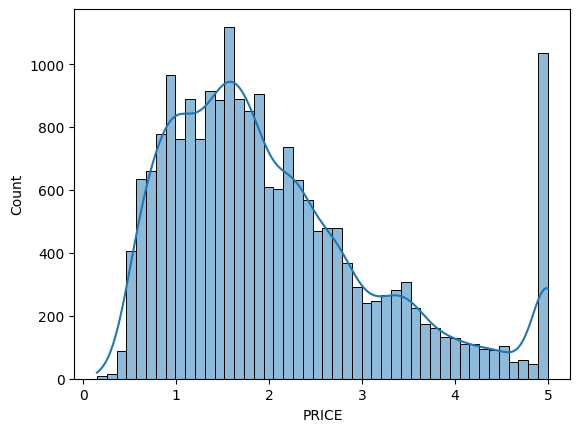

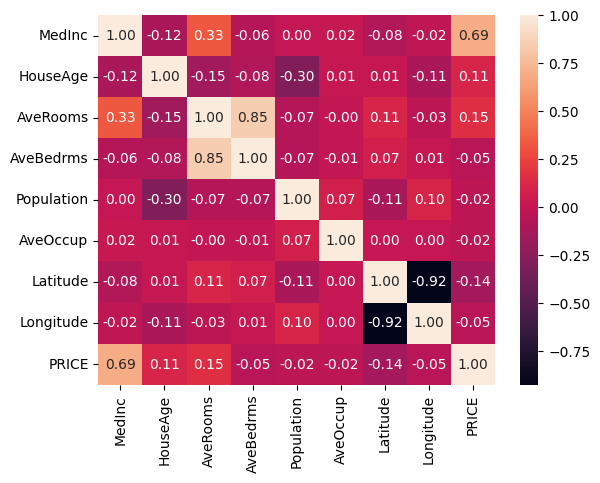

In [11]:
#Data Visualization

sns.histplot(data['PRICE'], kde=True)
plt.show()

corr_matrix = data.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f")
plt.show()


We note a **very strong negative correlation between latitude and longitude**, which is easily explained by California’s **geographic orientation**, stretching from the **northwest to the southeast**.

We also observe a **strong positive correlation between the average number of rooms (`AveRooms`) and the average number of bedrooms (`AveBedrms`)**. This is intuitive: houses with more rooms generally tend to have more bedrooms. This correlation suggests some **redundancy** between the two features.

In linear models, this kind of redundancy can lead to **multicollinearity**, which may affect the **stability of the coefficients** and hinder **model interpretability**. While **neural networks** are generally more robust to correlated inputs, removing or combining highly redundant features can sometimes lead to a **simpler and more efficient model**.


In [13]:
# Split into input features and target

X = data[housing.feature_names]
y = data['PRICE'].values.reshape(-1, 1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)

# Normalize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_normalized = scaler_X.fit_transform(X_train)
X_test_normalized = scaler_X.transform(X_test)

y_train_normalized = scaler_y.fit_transform(y_train)
y_test_normalized = scaler_y.transform(y_test)


We begin with a **simple feedforward neural network (FNN)** as a benchmark model for the California housing regression task. The architecture is as follows:

- 2 hidden layers, each with 64 nodes  
- ReLU activation functions  
- Adam optimizer with a learning rate of 0.0001  
- Mean Squared Error (MSE) as the loss function  
- Mean Absolute Error (MAE) as the evaluation metric

This architecture is chosen as a baseline because it is simple yet expressive enough to capture non-linear relationships in the data. Starting with a lightweight model allows us to establish a reference performance to compare future models against, while iterating quickly on hyperparameter choices and avoiding overfitting early in the experimentation process.

We will later experiment with different architectures, learning rates, and regularization techniques to improve performance.

/home/giov_armando/jupyter_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-03-22 19:23:48.094400: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.9021 - mae: 0.7192 - val_loss: 0.4731 - val_mae: 0.5071
Epoch 2/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.4120 - mae: 0.4778 - val_loss: 0.4113 - val_mae: 0.4644
Epoch 3/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3638 - mae: 0.4424 - val_loss: 0.3811 - val_mae: 0.4437
Epoch 4/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3374 - mae: 0.4236 - val_loss: 0.3611 - val_mae: 0.4284
Epoch 5/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3201 - mae: 0.4108 - val_loss: 0.3474 - val_mae: 0.4187
Epoch 6/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.3086 - mae: 0.4016 - val_loss: 0.3372 - val_mae: 0.4114
Epoch 7/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.2984 - mae: 0.3937 - val_loss: 0.3289 - val_mae: 0.4058
Epoch 8/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.2902 - mae: 0.3873 - val_loss: 0.3220 - val_mae: 0.4006
Epoch 9/50
523/523 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - lo

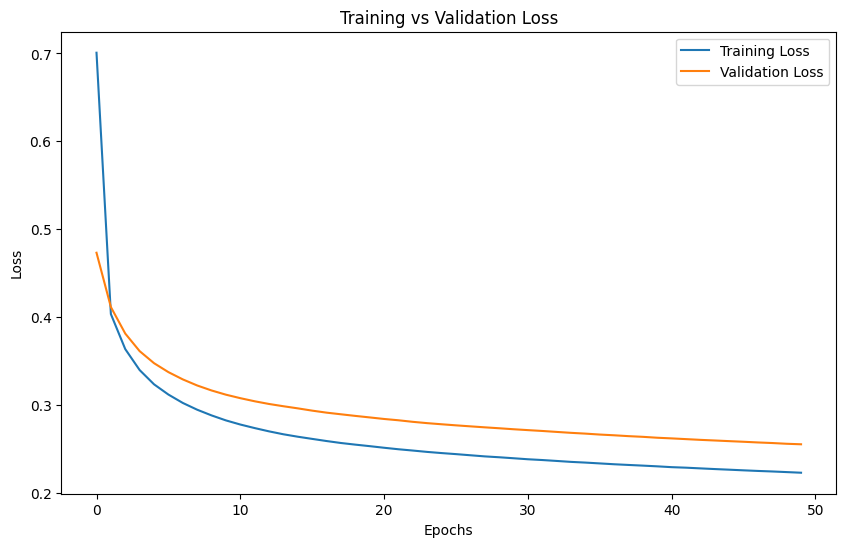

In [8]:
# Benchmark Neural Network

model = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_normalized.shape[1],)),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])


history = model.fit(
    X_train_normalized, y_train_normalized,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    verbose=1
)


# Evaluate the model on the training data
train_loss, train_mae = model.evaluate(X_train_normalized, y_train_normalized, verbose=1)
print(f"Train Loss: {train_loss}, Train MAE: {train_mae}")

# Evaluate the model on the test data
test_loss, test_mae = model.evaluate(X_test_normalized, y_test_normalized, verbose=1)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# Plotting the loss function (training and validation)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

The benchmark neural network achieved the following results:

- **Training loss**: 0.22  
- **Training MAE**: 0.324  
- **Test loss**: 0.236  
- **Test MAE**: 0.334

These results provide a reasonable baseline for the regression task. While the test error is not drastically higher than the training error, there may still be room for improvement through better hyperparameter tuning.

We now proceed with a **hyperparameter search** to explore whether different configurations (e.g., learning rates, number of hidden units, activation functions) can yield better performance.


Training model with lr=0.0001, neurons=64, dropout=0, activation=relu, batch_size=32, epochs=10
New best model saved with val_mae: 0.3908
Training model with lr=0.0001, neurons=64, dropout=0, activation=relu, batch_size=32, epochs=20
New best model saved with val_mae: 0.3670
Training model with lr=0.0001, neurons=64, dropout=0, activation=relu, batch_size=32, epochs=50
New best model saved with val_mae: 0.3436
Training model with lr=0.0001, neurons=64, dropout=0, activation=relu, batch_size=32, epochs=100
New best model saved with val_mae: 0.3243
Training model with lr=0.0001, neurons=64, dropout=0, activation=relu, batch_size=64, epochs=10
Training model with lr=0.0001, neurons=64, dropout=0, activation=relu, batch_size=64, epochs=20
Training model with lr=0.0001, neurons=64, dropout=0, activation=relu, batch_size=64, epochs=50
Training model with lr=0.0001, neurons=64, dropout=0, activation=relu, batch_size=64, epochs=100
Training model with lr=0.0001, neurons=64, dropout=0, activati

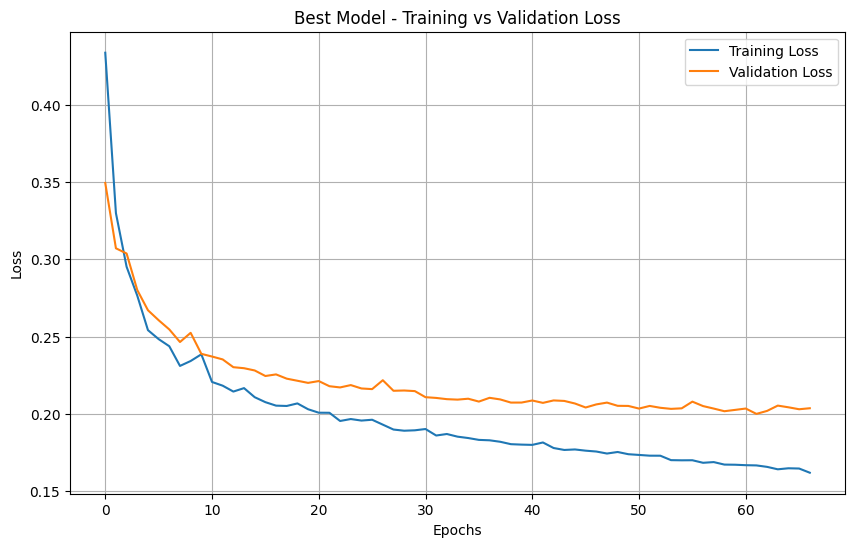

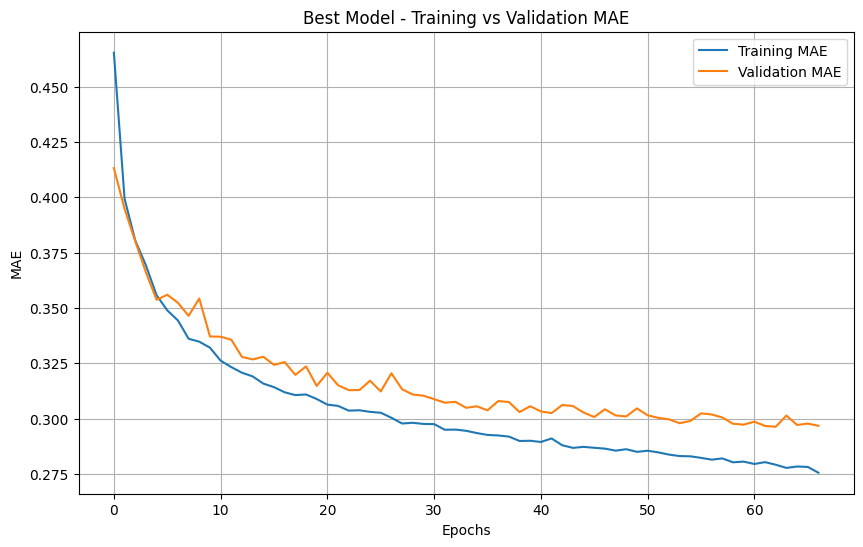

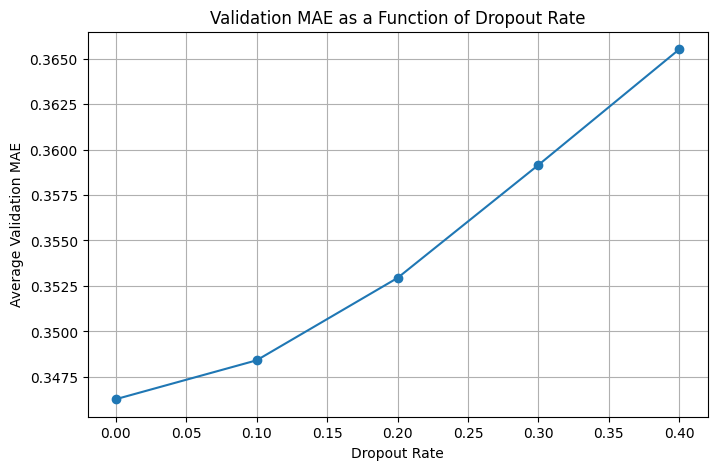


Total training time: 6655.62 seconds


In [11]:
# Hyperparameter Search

# Function to create and compile the model
def create_model(learning_rate, neurons, dropout_rate, activation):
    model = models.Sequential([
        layers.Dense(neurons, activation=activation, input_shape=(X_train_normalized.shape[1],)),
        layers.Dropout(dropout_rate),
        layers.Dense(neurons, activation=activation),
        layers.Dense(1)
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=MeanSquaredError(),
        metrics=[MeanAbsoluteError(name='mae')]  # Explicitly name the metric for consistency
    )
    return model

# Hyperparameter grid
learning_rates = [0.0001, 0.001]
neurons = [64, 128]
dropout_rates = [0, 0.1, 0.2, 0.3, 0.4]
activations = ['relu', 'tanh']
batch_sizes = [32, 64]
epochs = [10, 20, 50, 100]

param_combinations = itertools.product(learning_rates, neurons, dropout_rates, activations, batch_sizes, epochs)

# Tracking
results = []
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
start_time = time.time()

best_val_mae = float('inf')
best_model_path = 'best_model.keras'
best_history = None

# Hyperparameter search loop
for params in param_combinations:
    lr, neuron, dropout, activation, batch_size, epoch = params
    print(f"Training model with lr={lr}, neurons={neuron}, dropout={dropout}, activation={activation}, batch_size={batch_size}, epochs={epoch}")
    
    model = create_model(learning_rate=lr, neurons=neuron, dropout_rate=dropout, activation=activation)
    history = model.fit(
        X_train_normalized, y_train_normalized,
        validation_split=0.1,
        epochs=epoch,
        batch_size=batch_size,
        verbose=0,
        callbacks=[early_stopping]
    )
    
    val_loss = history.history['val_loss'][-1]
    val_mae = history.history['val_mae'][-1]

    results.append({
        'lr': lr,
        'neurons': neuron,
        'dropout': dropout,
        'activation': activation,
        'batch_size': batch_size,
        'epochs': epoch,
        'val_loss': val_loss,
        'val_mae': val_mae
    })

    if val_mae < best_val_mae:
        best_val_mae = val_mae
        best_history = history
        model.save(best_model_path)
        print(f"New best model saved with val_mae: {val_mae:.4f}")

# Load and evaluate the best model
best_model = tf.keras.models.load_model(best_model_path)
test_loss, test_mae = best_model.evaluate(X_test_normalized, y_test_normalized, verbose=1)
print(f"\nBest model test loss: {test_loss:.4f}, test MAE: {test_mae:.4f}")

# Plot training vs validation loss
plt.figure(figsize=(10, 6))
plt.plot(best_history.history['loss'], label='Training Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Best Model - Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

# Plot training vs validation MAE
plt.figure(figsize=(10, 6))
plt.plot(best_history.history['mae'], label='Training MAE')
plt.plot(best_history.history['val_mae'], label='Validation MAE')
plt.title('Best Model - Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()

# Dropout rate vs avg validation MAE
dropout_mae = {}
for result in results:
    dropout = result['dropout']
    mae = result['val_mae']
    if dropout not in dropout_mae:
        dropout_mae[dropout] = []
    dropout_mae[dropout].append(mae)

dropout_avg_mae = {key: np.mean(values) for key, values in dropout_mae.items()}

plt.figure(figsize=(8, 5))
plt.plot(list(dropout_avg_mae.keys()), list(dropout_avg_mae.values()), marker='o')
plt.title('Validation MAE as a Function of Dropout Rate')
plt.xlabel('Dropout Rate')
plt.ylabel('Average Validation MAE')
plt.grid()
plt.show()

# Elapsed time
elapsed_time = time.time() - start_time
print(f"\nTotal training time: {elapsed_time:.2f} seconds")


In [14]:
# Load the best model
best_model = load_model("best_model.keras")

# Evaluate on training set
train_loss, train_mae = best_model.evaluate(X_train_normalized, y_train_normalized, verbose=0)

# Evaluate on test set
test_loss, test_mae = best_model.evaluate(X_test_normalized, y_test_normalized, verbose=0)

# Compute variance
mae_variance = abs(train_mae - test_mae)

# Print results
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE:     {test_mae:.4f}")
print(f"Variance:     {mae_variance:.4f}")


Training MAE: 0.2686
Test MAE:     0.2960
Variance:     0.0274


In [18]:
# Inverse transform MAE values to original scale (dollar value)
train_mae_rescaled = scaler_y.inverse_transform([[train_mae]])[0][0]
test_mae_rescaled = scaler_y.inverse_transform([[test_mae]])[0][0]

print(f"Rescaled Training MAE: ${train_mae_rescaled*10000:,.2f}")
print(f"Rescaled Test MAE:     ${test_mae_rescaled*10000:,.2f}")

Rescaled Training MAE: $23,785.26
Rescaled Test MAE:     $24,101.71


The best model achieves a **training MAE of 0.2686** and a **test MAE of 0.2960**, resulting in a **variance of 0.0274**.

This small variance suggests that the model generalizes well to unseen data and exhibits minimal overfitting. It also confirms that the selected architecture and hyperparameters strike an effective balance between model capacity and regularization.

Moreover, the final dropout experiment shows that the **validation MAE increases monotonically with the dropout rate**, indicating that in this case, **dropout may actually hinder performance**. Simpler architectures without explicit regularization appear better suited for structured datasets like this one.


### Final Comparison and Conclusion

The initial benchmark model, with two hidden layers of 64 neurons and no dropout, achieved a **training MAE of 0.326** (`~$32,600`), a **test MAE of 0.334** (`~$33,400`), and a variance of **0.008**. While the variance was already low, the overall prediction error left room for improvement.

After performing a randomized hyperparameter search, the best model achieves a **training MAE of 0.2686** (`~$26,900`) and a **test MAE of 0.2960** (`~$29,600`), with a variance of **0.0274**. This represents a **clear improvement in both training and generalization performance**, reducing the test MAE by more than 10%.

Interestingly, the final model does **not rely on dropout**, and experiments showed that increasing dropout tended to worsen validation performance. This suggests that for this structured regression task, a well-tuned model without explicit regularization can perform better.

Overall, this project demonstrates how a combination of careful data preprocessing, model benchmarking, and efficient hyperparameter tuning can lead to a highly effective predictive model for housing price estimation.
